# 数据处理
- 原始信号仅仅按照样本熵进行分块，无其他处理；
- 标签使用的是独热编码；

In [1]:
import os  
import pandas as pd  
import matplotlib.pyplot as plt
  
    #step1:加载数据集
# 设置数据集的路径  
data_dir = '/kaggle/input/110spm/110SPM/pressure'   
# 创建空的列表来存储所有的DataFrame  
X_data0 = []  
y_data0 = []
# 遍历指定目录下的所有文件  
for filename in os.listdir(data_dir):  
    if filename.endswith('.csv'):  
        # 构建文件的完整路径  
        file_path = os.path.join(data_dir, filename)  
        # 读取Excel文件  
        df = pd.read_csv(file_path)
        serie=df.iloc[:, 0]
        version_without_extension = filename.rsplit(".", 1)[0] 
        serie.name=version_without_extension
        # 将读取的DataFrame添加到列表中  
        X_data0.append(serie)
        y_data0.append(version_without_extension)

    #step2:遍历X_data0中的每个DataFrame，并删除非数字数据  
cleaned_data = []  
for df in X_data0:  
    df_cleaned = df[pd.to_numeric(df, errors='coerce').notnull()]  
    cleaned_data.append(df_cleaned)  
 

    #step3:将X_data0中的每个DataFrame的所有元素变为float类型 
for i, df in enumerate(cleaned_data):  
    X_data0[i] = df.astype(float) 

# 初始化X_data1来存储结果  
X_data1 = []  
  
# 遍历X_data0中的每个Series  
for series in X_data0:  
    # 计算步长（由于重叠率为50%，步长为序列长度的一半）  
    step_size = 256  # 因为512的一半是256，且我们想要50%的重叠  
    # 初始化一个空的list来存储子序列  
    subsequences = []  
    # 使用range和步长来生成子序列  
    for i in range(0, len(series) - 512 + 1, step_size):  
        # 确保切片是一维的，并转换为Series（虽然这里切片已经是Series）  
        subsequence = series.iloc[i:i+512]  
        subsequences.append(subsequence) 
    X_data1.append(subsequences)  
type(X_data1),len(X_data1),len(X_data1[0])

/tmp/ipykernel_18/1281161320.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/tmp/ipykernel_18/1281161320.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


(list, 12, 4213)

In [2]:
import pandas as pd  
import numpy as np  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder  
from keras.utils import to_categorical
import time  
from keras.callbacks import Callback  
# 假设 X_data1 已经定义好了  
all_data = []  
all_labels = []  
  
for sublist in X_data1:  
    for series in sublist:  
        # 假设每个series是pandas Series  
        all_data.append(series.values)  
        all_labels.append(series.name)  
  
# 将数据转换为numpy数组  
data_array = np.array(all_data)  
# 将标签转换为编码  

label_encoder = LabelEncoder()  
labels_encoded = label_encoder.fit_transform(all_labels)  
  
# 如果需要one-hot编码  
labels_one_hot = to_categorical(labels_encoded)  
  
# 这里你可能需要reshape data_array 以符合LSTM的输入要求  
# LSTM通常要求输入形状为 (samples, time_steps, features)  
# 假设每个series的长度相同，或者你可以填充/截断它们以具有相同的长度  
time_steps = data_array.shape[1]  # 假设所有series长度相同  
data_array = data_array.reshape(-1, time_steps, 1)  # 增加一个维度以匹配LSTM的输入要求

# 分割数据集  
X_train, X_temp, y_train, y_temp = train_test_split(data_array, labels_one_hot, test_size=0.3, random_state=42)  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



2024-07-09 03:43:09.558434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 03:43:09.558556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 03:43:09.709017: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 训练LSTM模型
- 直接使用原始信号训练LSTM；
- 查看训练过程中的loss和val_loss的变化图；

In [3]:

from keras.models import Sequential  
from keras.layers import LSTM, Dense  
  
model = Sequential()  
model.add(LSTM(50, input_shape=(time_steps, 1)))  
model.add(Dense(labels_one_hot.shape[1], activation='softmax'))  
  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


class TimeBasedCheckpoint(Callback):  
    def __init__(self, filepath, time_interval_hours=4, verbose=0, save_weights_only=False):  
        super(TimeBasedCheckpoint, self).__init__()  
        self.filepath = filepath  
        self.time_interval_hours = time_interval_hours  
        self.verbose = verbose  
        self.save_weights_only = save_weights_only  
        self.last_save_time = None  
  
    def on_epoch_begin(self, epoch, logs=None):  
        if self.last_save_time is None:  
            self.last_save_time = time.time()  
            return  
  
        current_time = time.time()  
        elapsed_time = current_time - self.last_save_time  
        if elapsed_time / 3600 >= self.time_interval_hours:  
            self.save_model(epoch, logs)  
            self.last_save_time = current_time  
  
    def save_model(self, epoch, logs=None):  
        filepath = self.filepath.format(epoch=epoch + 1)  # 假设您想将epoch编号包含在文件名中  
        if self.save_weights_only:  
            self.model.save_weights(filepath, overwrite=True)  
        else:  
            self.model.save(filepath, overwrite=True)  
        if self.verbose > 0:  
            print(f'Model saved to {filepath} at epoch {epoch + 1}')  


checkpoint = TimeBasedCheckpoint(filepath='/kaggle/working/model.h5', time_interval_hours=4, verbose=1)  
history=model.fit(X_train, y_train, epochs=100, batch_size=32 ,callbacks=[checkpoint] ,validation_data=(X_val, y_val))
model.save("/kaggle/working/model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 225s 160ms/step - accuracy: 0.1440 - loss: 2.3567 - val_accuracy: 0.1484 - val_loss: 2.3247
Epoch 2/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 222s 160ms/step - accuracy: 0.1491 - loss: 2.3156 - val_accuracy: 0.1668 - val_loss: 2.2674
Epoch 3/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 222s 160ms/step - accuracy: 0.1759 - loss: 2.2399 - val_accuracy: 0.2323 - val_loss: 2.1160
Epoch 4/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 223s 161ms/step - accuracy: 0.2116 - loss: 2.1559 - val_accuracy: 0.1650 - val_loss: 2.2502
Epoch 5/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 264s 162ms/step - accuracy: 0.2313 - loss: 2.0786 - val_accuracy: 0.3069 - val_loss: 1.8111
Epoch 6/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 229s 164ms/step - accuracy: 0.2971 - loss: 1.8016 - val_accuracy: 0.3208 - val_loss: 1.7119
Epoch 7/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 264s 166ms/step - accuracy: 0.3299 - loss: 1.7063 - val_accuracy: 0.3193 - val_loss: 1.7223
Epoch 8/100
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 255s 162ms/s

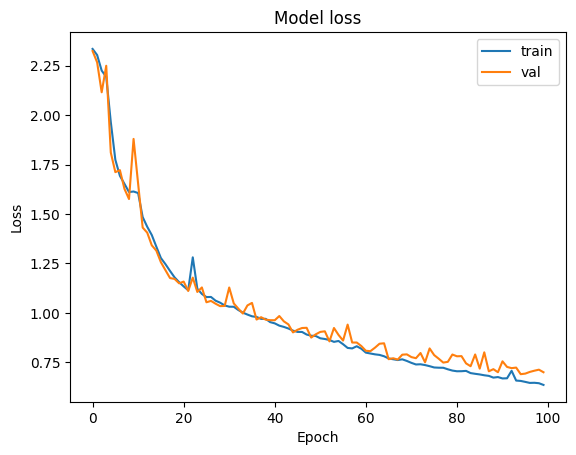

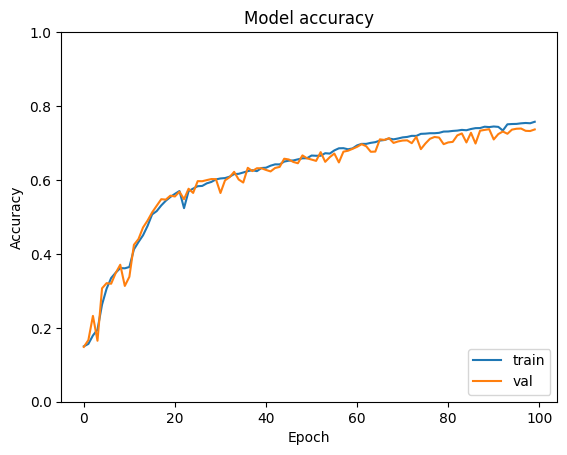

In [4]:
import matplotlib.pyplot as plt 
# 绘制训练loss和验证loss  
plt.plot(history.history['loss'], label='train')  
plt.plot(history.history['val_loss'], label='val')  
plt.legend(loc='upper right')  
plt.title('Model loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.show()  
  
# 绘制训练accuracy和验证accuracy  
plt.plot(history.history['accuracy'], label='train')  
plt.plot(history.history['val_accuracy'], label='val')  
plt.legend(loc='lower right')  
plt.title('Model accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.ylim(ymin=0, ymax=1)  # 设置y轴的范围为0到1  
plt.show()

# 评估模型效果
- 使用测试集获得loss函数为0.4971，准确率为0.8328；(效果不乍地)
- 混淆矩阵勉强看着还行；
- 精确率（precision）和召回率（recall）
- 类别8和11的f1-score小于80%，模型对于这两个的预测效果不好；


精确率衡量的是模型预测为正类的样本中，真正为正类的比例；召回率衡量的是所有正类样本中，被模型正确预测为正类的比例。F1分数则是这两个指标的调和平均，因此它同时考虑了模型的精确度和其对所有类别的覆盖率（或灵敏度）。'macro': 简单地对每个类别的F1分数进行未加权平均，赋予每个类别相同的权重，不考虑它们各自的样本数。'weighted': 对每个类别的F1分数进行加权平均，权重是每个类别的支持度（即每个类别的样本数）。这可以看作是对每个类别重要性的一种度量。

299/299 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step


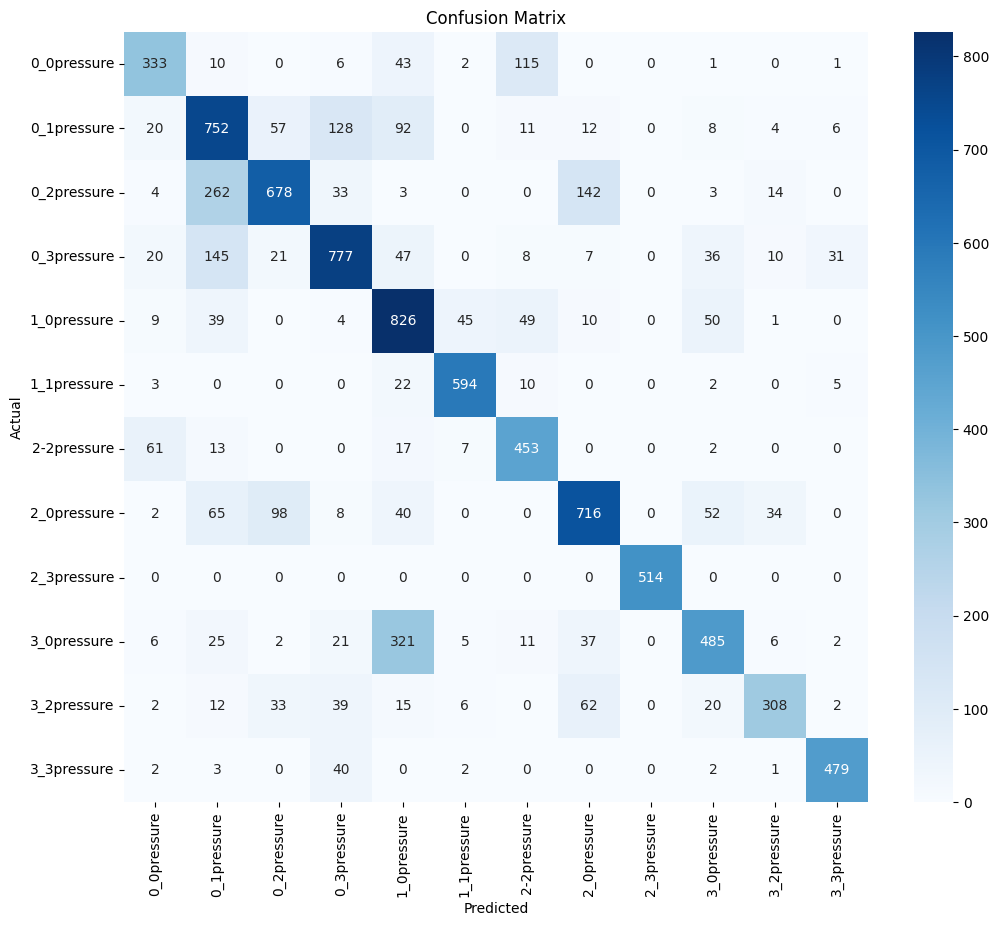

299/299 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.7211 - loss: 0.7253
Test loss: 0.7153
Test accuracy: 0.7247


In [5]:
from tensorflow.keras.models import load_model  
from sklearn.metrics import confusion_matrix  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
  
# # 加载模型  
# model = load_model("/kaggle/input/110spmlstm/keras/110spmlstm/1/model.h5")  
  
# 假设X_test和y_test是你的测试数据和真实标签（整数索引）  
# 这里需要你已经有了这些变量  
  
# 预测测试集  
y_pred = model.predict(X_test)  
# 对于多分类问题，使用argmax获取预测类别索引  
y_pred_classes = np.argmax(y_pred, axis=1)  
   
# 计算混淆矩阵  
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)  # 确保y_test也是索引形式  
  
# 获取所有唯一标签的列表，这些标签将对应于整数编码的索引  
class_names = label_encoder.classes_  

# 绘制混淆矩阵  
plt.figure(figsize=(12, 10))  
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)  
plt.ylabel('Actual')  
plt.xlabel('Predicted')  
plt.title('Confusion Matrix')  
plt.show()

# 评估模型  
loss, accuracy = model.evaluate(X_test, y_test)  
print(f'Test loss: {loss:.4f}')  
print(f'Test accuracy: {accuracy:.4f}')

In [6]:
from sklearn.metrics import f1_score, classification_report  
import numpy as np  
  
# 假设 X_test 和 y_test 已经是准备好的测试集数据和标签  
  
# 使用模型进行预测  
y_pred_probs = model.predict(X_test)  # 获取预测的概率  
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # 将概率转换为类别标签  
  
# 注意：如果你的 y_test 是one-hot编码的，你需要先将其转换为类别索引  
y_true_classes = np.argmax(y_test, axis=1)  # 假设 y_test 是one-hot编码的  
  
# 计算F1分数  
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # 使用加权平均来计算多类别的F1分数  
print(f'F1 Score: {f1:.4f}')  
  
# 计算精确率、召回率和F1分数的详细报告  
report = classification_report(y_true_classes, y_pred_classes)  
print(report)

299/299 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step
F1 Score: 0.7242
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       511
           1       0.57      0.69      0.62      1090
           2       0.76      0.60      0.67      1139
           3       0.74      0.71      0.72      1102
           4       0.58      0.80      0.67      1033
           5       0.90      0.93      0.92       636
           6       0.69      0.82      0.75       553
           7       0.73      0.71      0.72      1015
           8       1.00      1.00      1.00       514
           9       0.73      0.53      0.61       921
          10       0.81      0.62      0.70       499
          11       0.91      0.91      0.91       529

    accuracy                           0.72      9542
   macro avg       0.76      0.75      0.75      9542
weighted avg       0.74      0.72      0.72      9542

